## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import glob
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import copy
import pandas as pd
import numpy as np
import torch

from sklearn.metrics import roc_auc_score

os.environ["WANDB_SILENT"] = "true"

from owkin.training import train, RocLoss
from owkin.dataset import build_dataset
from owkin.models.mono_models import MLP, SVM
from owkin.models.aggregators import SmoothMaxAggregator, MaxAggregator

## Get the Data

In [3]:
X_train, X_train_mean, y_train, X_val, X_val_mean, y_val, X_test, X_test_mean, df_test = build_dataset()

## Training

In [4]:
list_kernel = ['linear', 'poly', 'rbf', 'sigmoid']
list_C = [1e-2, 1e-1, 1e-0, 1e1, 1e2]

In [13]:
mono_res = {}
agg_res = {}

In [22]:
for kernel in list_kernel:
    mono_res[kernel] = dict()
    agg_res[kernel] = dict()
    for C in list_C:    
        mono_model = SVM(C=C, kernel=kernel)
        mono_model.svm.fit(X_train_mean, y_train)
        mono_val_pred = mono_model(X_val_mean)
        model = SmoothMaxAggregator(mono_model)
        val_pred = model(X_val)
        mono_res[kernel][C] = roc_auc_score(y_val, mono_val_pred)
        agg_res[kernel][C] = roc_auc_score(y_val, val_pred)
#        print(f"kernel={kernel.ljust(7)}, C={'{:.0e}'.format(C)}, mono_val_score = {'{:.3f}'.format(roc_auc_score(y_val, mono_val_pred))}, val_score={'{:.3f}'.format(roc_auc_score(y_val, val_pred))}")

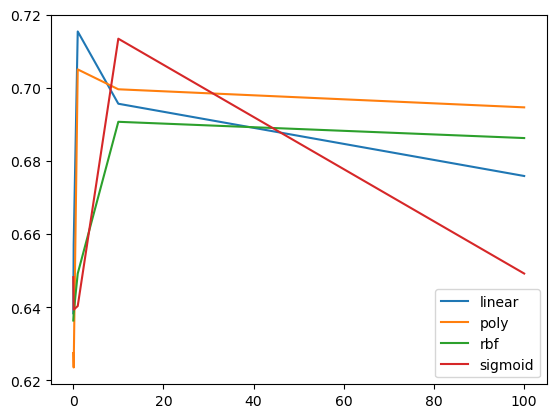

In [26]:
for kernel in list_kernel:
    plt.plot(list(mono_res[kernel].keys()), list(mono_res[kernel].values()), label = kernel)
plt.legend()
plt.show()

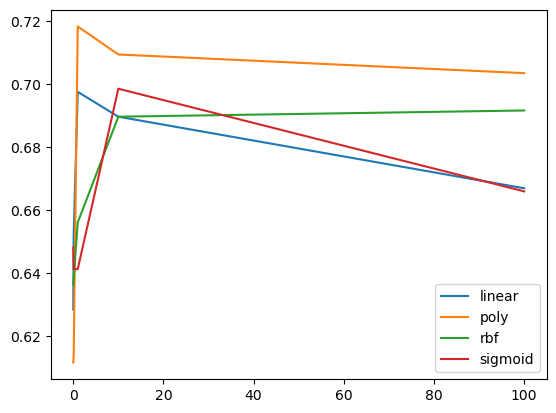

In [27]:
for kernel in list_kernel:
    plt.plot(list(agg_res[kernel].keys()), list(agg_res[kernel].values()), label = kernel)
plt.legend()
plt.show()